## Image Captioning : part I

#### AhmadReza Nopoush
#### id: 610301194


### Step 1
at the begining, we import the libraries we need.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm


import tensorflow.keras.applications.resnet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

### Step 2: Import DataSet from Kaggle

here we import flickr8k dataset from kaggle as below:

In [2]:
pip install opendatasets

In [3]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k/data")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmadnp
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


100%|██████████| 1.04G/1.04G [00:49<00:00, 22.5MB/s]


### Step 3
in this step we load the captions, then we edit it in order to tokenize it better. we define `mapping` which is a dictionary that it keys ia a name of each images and its values are the captions of that image.

Now we open caption file...

In [6]:
with open(os.path.join('flickr8k/captions.txt'), 'r') as f:
  #skips the first line
  next(f)
  captions_doc = f.read()

In [7]:
#Create a dictionary of image names to captions

mapping = dict()

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

the schema of `mapping` you can see as below:

In [8]:
print("length of mapping: ", len(mapping))

length of mapping:  8091


In [9]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

### Step 4
in this step we define the `All_Captions`, which is a list of the whole captions that we have. We pass the captions through a filter so that all captions are uniformly converted into a set of pure words. so we define a function `Cleaner` that remove all of the non-Alphabet charecters and replace capital letters to small letters.

In [10]:
def Cleaner(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            for char in caption:
              if not char.isalpha() or not char.isspace():
                caption.replace(char,'')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption


Cleaner(mapping)

In [11]:
All_Captions = list()
for key in mapping:
    for caption in mapping[key]:
        All_Captions.append(caption)

print("the size of all sentences is: ",len(All_Captions))
All_Captions[:10]

the size of all sentences is:  40455


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

### Step 5:
Now, we define the `tokenize` function. This function assigns a number to each word of all the words we have and returns it as a dictionary. For this, we give the list `All_Captions` we got before as input to the function. The function breaks it into a set of valid words and assigns a number to each member.

Then, we define the `TexttoSeq` function. According to the dictionary we produced, this function assigns a list of numbers to each caption that is input as a string, where each number is the number of the corresponding word in the dictionary.

by this two function we can tokenize the string and give that to the encoder RNN model.

In [14]:
def tokenize(all_captions):
  dictionary = dict()
  dictionary['startseq'] = 1
  dictionary['endseq'] = 2
  flag = 3

  for cap in all_captions:
    capn = cap.split()
    for word in capn:
      word = word.replace('[^A-Za-z]', '')
      word = word.replace('"', '')
      word = word.replace("'", '')
      if len(word) < 2:
        continue
      if word not in dictionary.keys():
        dictionary[word] = flag
        flag += 1

  return dictionary

def TexttoSeq(dictionary, string):
  array = list()

  caption = string.split()
  for word in caption:
    word = word.replace('[^A-Za-z]', '')
    word = word.replace('"', '')
    word = word.replace("'", '')
    if len(word) < 2:
      continue
    if word in dictionary.keys():
      array.append(dictionary[word])

  return array

Tokenized = tokenize(All_Captions)
vocab_size = len(Tokenized)

In [15]:
print("the vocabulary size is: ", vocab_size)

the vocabulary size is:  8884


In [16]:
# maximum length of the caption available
max_length = max(len(caption.split()) for caption in All_Captions)

max_length

35

### Step 6
in this step we divide our dataset into train and test data.

In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

### Step 7: Construct the CNN Encoder
here, we develop the CNN part. as there is no RESNET18 in keras, we used ResNet50 instead. we set
```
model.trainable = False
```
so the CNN part is untrainable as part 1 of project asks from us. we summarized the model so we can see descreptions of the encoder as below




In [18]:
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights='imagenet')
model.trainable = False

model.summary()

102967424/102967424 [==============================] - 6s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

### Image Processing
here we process all of the images. first, we load each image and conver it to an array with size (224, 224). then we reshape the array in order to be given to CNN decoder. then we give the reshaped array to `model` to extract features from image. then we update the `features` dictionary which the keys are name of an image and the values are the extracted features.

In [19]:
#extract features from image

features = {}
directory = os.path.join('flickr8k/Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

### Step 8
Now we define the `data-generator`. this function helps the model to take the input data (captions) as a list of numbers (with the help of tokenizer we build-up) in batches.

In [20]:
#creating data generator to get data in batch

def data_generator(data_keys, mapping, Tokenized, features, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = TexttoSeq(Tokenized, caption)
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

#### Encoder RNN Model:
now we build the encoder part. this encoder tries to make relations between the features that we got from CNN decoder and the array of numbers that we tokenized the captios. also we set `loss='categorical_crossentropy', optimizer='adam'` as project asks from us. you can see the plot of encoder as below:

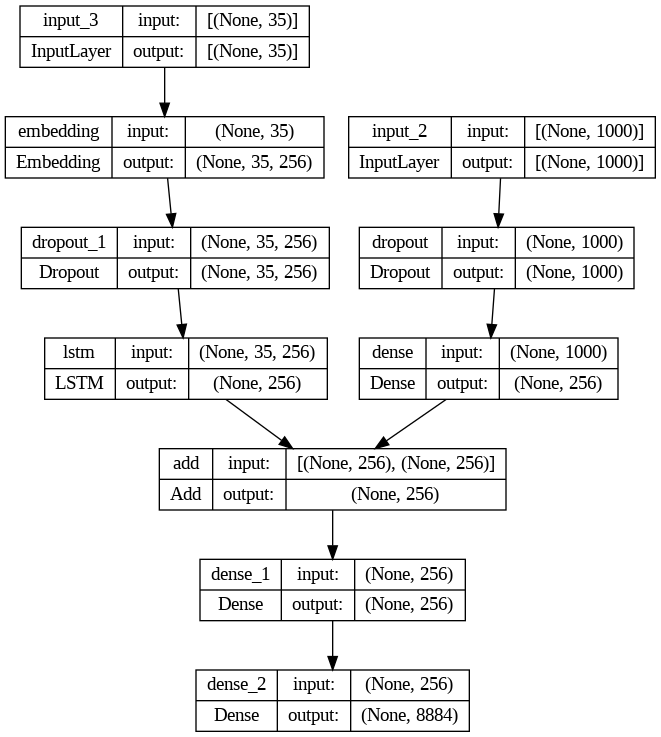

In [21]:
#image feature layers
inputs1 = Input(shape=(1000,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

#sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


#decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

### Step 9: Train the model

Now we can train the encoder part of our model

In [23]:
#initializing epochs and batches
epochs = 7
batch_size = 32
steps = len(train) // batch_size

#train the encoder
for i in range(epochs):
    generator = data_generator(train, mapping, Tokenized, features, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=3, steps_per_epoch=steps, verbose=1)

Epoch 1/3
227/227 [==============================] - 70s 271ms/step - loss: 5.7523
Epoch 2/3
227/227 [==============================] - 55s 243ms/step - loss: 4.6355
Epoch 3/3
227/227 [==============================] - 55s 242ms/step - loss: 4.2412
Epoch 1/3
227/227 [==============================] - 54s 239ms/step - loss: 3.9980
Epoch 2/3
227/227 [==============================] - 54s 237ms/step - loss: 3.8202
Epoch 3/3
227/227 [==============================] - 54s 239ms/step - loss: 3.6729
Epoch 1/3
227/227 [==============================] - 55s 240ms/step - loss: 3.5510
Epoch 2/3
227/227 [==============================] - 56s 247ms/step - loss: 3.4422
Epoch 3/3
227/227 [==============================] - 55s 244ms/step - loss: 3.3470
Epoch 1/3
227/227 [==============================] - 57s 249ms/step - loss: 3.2611
Epoch 2/3
227/227 [==============================] - 55s 241ms/step - loss: 3.1833
Epoch 3/3
227/227 [==============================] - 55s 243ms/step - loss: 3.1130
Epoc

### Step 10:
in the last step we define three functions:
1. `idx_to_word`: this function just reversley convert a list of array to a sentence(caption) by using the `Tokenized` dictionary.

2. `prdict_caption`: this function gave the model the name of images, and the model give an array of numbers back. then this function turn this array to string and return it, which is an expected captions.

3. `generate_captins`: this function simply get the name of image, then show its captions and the caption that model predict, then it plot the image so we can judge the model.

In [24]:
def idx_to_word(integer, Tokenized):
    for word, index in Tokenized.items():
        if index == integer:
            return word
    return None

In [25]:
#generate caption for an image
def predict_caption(model, image, Tokenized, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = TexttoSeq(Tokenized, in_text)
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, Tokenized)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):

    image_id = image_name.split('.')[0]
    img_path = os.path.join("flickr8k/Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, features[image_id], Tokenized, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')

### Step 11: Test the model on test data!
Now after training we can test our model on unseen images:

---------------------Actual---------------------
startseq woman smile and wave to the camera endseq
startseq woman in red shirt is waving while standing behind another woman with black hair endseq
startseq woman in pink is staring while woman is red is posing nearby kitchen items endseq
startseq two women are smiling together at restaurant endseq
startseq two women in front of boxes of tea and cups endseq
--------------------Predicted--------------------
startseq two girls are posing for picture endseq


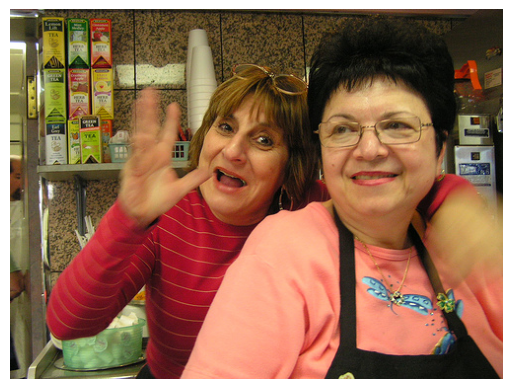

In [38]:
ri1 = np.random.randint(0,len(test)-1)
generate_caption(test[ri1]+'.jpg')

---------------------Actual---------------------
startseq person in dress and pink feathered hat rides unicycle in parade endseq
startseq person is riding unicycle on the street with many other people around endseq
startseq person wearing black and pink outfit and hat riding atop unicycle down the street endseq
startseq "a woman wearing black and pink and large feathered hat rides bike in parade ." endseq
startseq woman in black dress and hat rides unicycle in front of crowd endseq
--------------------Predicted--------------------
startseq man in red shirt and blue shirt is riding unicycle endseq


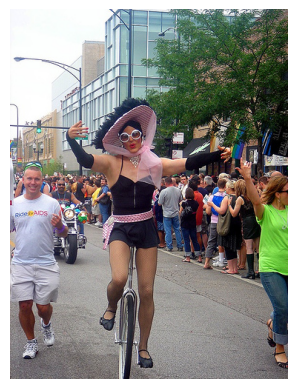

In [39]:
ri2 = np.random.randint(0,len(test)-1)
generate_caption(test[ri2]+'.jpg')

---------------------Actual---------------------
startseq brown dog walks in the under brush endseq
startseq dog pauses in the bushes endseq
startseq dog runs through the long grass endseq
startseq brown dog with mouth open standing amidst greenery endseq
startseq brown long-haired dog in garden endseq
--------------------Predicted--------------------
startseq dog is jumping over log endseq


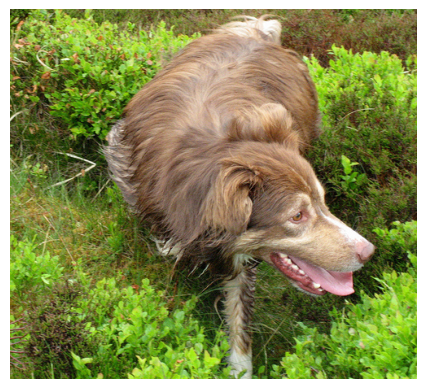

In [42]:
ri3 = np.random.randint(0,len(test)-1)
generate_caption(test[ri3]+'.jpg')

---------------------Actual---------------------
startseq girl in pool wearing goggles and surrounded by other children endseq
startseq girl in green goggles in pool with three other children endseq
startseq red haired girl making peace sign is wearing neon green glasses and floaties and playing in the pool with other kids endseq
startseq red-headed girl offers the peace sign as she swims in the pool with floaties endseq
startseq young girl with goggles and floaties poses for the camera as she plays in pool endseq
--------------------Predicted--------------------
startseq young girl in pink bathing suit is jumping into pool endseq


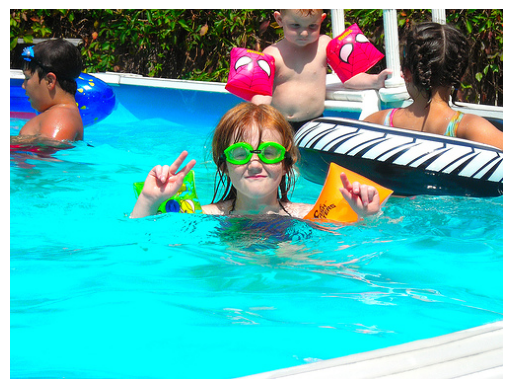

In [41]:
ri4 = np.random.randint(0,len(test)-1)
generate_caption(test[ri4]+'.jpg')

### Conclusion:

As we can see from the results, most of the time, the model has the ability to recognize the main components or features of the image. But it works poorly in analyzing the details of the image, and this makes the generated sentence look a little wrong or funny. This shows that first, the CNN decoder part of model works well; Because it recognizes the features correctly. But probably the RNN encoder part works poorly, which may be due to poor tokenization or even the model is not trained well enough.